In [27]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [14]:
n_feature = 2
n_class = 2

In [13]:
def make_network(n_hidden=100):
    model = dict(
        W1=np.random.randn(n_feature, n_hidden),
        W2=np.random.randn(n_hidden, n_class)
    )

    return model

In [16]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [37]:
def forward(x, model):
    # Input to hidden
    h = x @ model['W1']
    h[h < 0] = 0
    # Hidden to output
    prob = softmax(h @ model['W2'])
    return h, prob

def backward(model, xs, hs, errs):
    dW2 = hs.T @ errs
    dh = errs @ model['W2'].T
    dh[hs < 0] = 0
    dW1 = xs.T @ dh
    return dict(W1=dW1, W2=dW2)

def get_minibatch_grad(model, X_train, y_train):
    xs, hs, errs = [], [], []
    for x, cls_idx in zip(X_train, y_train):
        h, y_pred = forward(x, model)
        y_true = np.zeros(n_class)
        y_true[int(cls_idx)] = 1.
        err = y_true - y_pred
        mean_error = err.mean()
        xs.append(x)
        hs.append(h)
        errs.append(err)
    return backward(model, np.array(xs), np.array(hs), np.array(errs))

def get_errors_for_batch(model,X_train,y_train):
    xs, hs, errs = [], [], []
    for x, cls_idx in zip(X_train, y_train):
        h, y_pred = forward(x, model)
        y_true = np.zeros(n_class)
        y_true[int(cls_idx)] = 1.
        err = y_true - y_pred
        xs.append(x)
        hs.append(h)
        errs.append(err)
    return np.array(errs).mean()

def get_minibatch(X, y, minibatch_size):
    minibatches = []

    X, y = shuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]

        minibatches.append((X_mini, y_mini))

    return minibatches


def sgd(model,X_train,y_train,mini_batch_size):
    minibatches = get_minibatch(X_train,y_train,minibatch_size)
    for iter in range(1,n_iter + 1):
        idx = np.random.randint(0,len(minibatches))
        x_mini,y_mini = minibatches[idx]
        grad = get_minibatch_grad(model,x_mini,y_mini)
        for layer in grad:
            model[layer] += alpha *grad[layer]
    return model

def momentum(model, X_train, y_train, minibatch_size):
    velocity = {k: np.zeros_like(v) for k, v in model.items()}
    gamma = .9
    minibatches = get_minibatch(X_train, y_train, minibatch_size)
    for iter in range(1, n_iter + 1):
        idx = np.random.randint(0, len(minibatches))
        X_mini, y_mini = minibatches[idx]
        grad = get_minibatch_grad(model, X_mini, y_mini)
        for layer in grad:
            velocity[layer] = gamma * velocity[layer] + alpha * grad[layer]
            model[layer] += velocity[layer]
    return model

def nesterov(model, X_train, y_train, minibatch_size):
    velocity = {k: np.zeros_like(v) for k, v in model.items()}
    gamma = .9
    minibatches = get_minibatch(X_train, y_train, minibatch_size)
    for iter in range(1, n_iter + 1):
        idx = np.random.randint(0, len(minibatches))
        X_mini, y_mini = minibatches[idx]
        model_ahead = {k: v + gamma * velocity[k] for k, v in model.items()}
        grad = get_minibatch_grad(model, X_mini, y_mini)
        for layer in grad:
            velocity[layer] = gamma * velocity[layer] + alpha * grad[layer]
            model[layer] += velocity[layer]

    return model

def adagrad(model, X_train, y_train, minibatch_size):
    cache = {k: np.zeros_like(v) for k, v in model.items()}

    minibatches = get_minibatch(X_train, y_train, minibatch_size)
    error = []
    for iter in range(1, n_iter + 1):
        idx = np.random.randint(0, len(minibatches))
        X_mini, y_mini = minibatches[idx]

        grad = get_minibatch_grad(model, X_mini, y_mini)

        for k in grad:
            cache[k] += grad[k]**2
            model[k] += alpha * grad[k] / (np.sqrt(cache[k]) + eps)
        error.append(get_errors_for_batch(model, X_mini, y_mini))

    return model,error

def adam(model, X_train, y_train, minibatch_size):
    M = {k: np.zeros_like(v) for k, v in model.items()}
    R = {k: np.zeros_like(v) for k, v in model.items()}
    beta1 = .9
    beta2 = .999

    minibatches = get_minibatch(X_train, y_train, minibatch_size)

    for iter in range(1, n_iter + 1):
        t = iter
        idx = np.random.randint(0, len(minibatches))
        X_mini, y_mini = minibatches[idx]

        grad = get_minibatch_grad(model, X_mini, y_mini)

        for k in grad:
            M[k] = beta1 * M[k] + (1. - beta1) * grad[k]
            R[k] = beta2 * R[k] + (1. - beta2) * grad[k]**2

            m_k_hat = M[k] / (1. - beta1**(t))
            r_k_hat = R[k] / (1. - beta2**(t))

            model[k] += alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

    return model
    

In [38]:
def shuffle(X, y):
    Z = np.column_stack((X, y))
    np.random.shuffle(Z)
    return Z[:, :-1], Z[:, -1]

In [39]:
X, y = make_moons(n_samples=5000, random_state=42, noise=0.1)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [48]:
n_iter = 100
eps = 1e-8  # Smoothing to avoid division by zero
alpha = 1e-2
minibatch_size = 100
n_experiment = 3
algos = dict(
    sgd=sgd,
    momentum=momentum,
    nesterov=nesterov,
    adagrad=adagrad,
    adam=adam
)

In [49]:
model = make_network()
model,error = adagrad(model,X_train,y_train,minibatch_size)

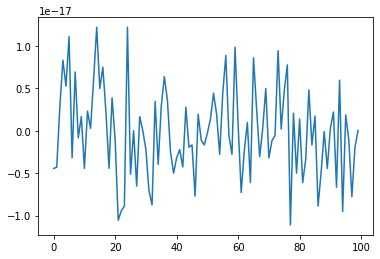

In [50]:
plt.plot(np.arange(0,100),error)